In [5]:
import os
import itertools
import time
import json

import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from pathlib import Path
%matplotlib inline

from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.model_selection import KFold

## Feature Exploration, Engineering and Cleaning

In [11]:
# Load datasets 好慢啊
goods_promote_price = pd.read_csv('../datasets/goods_promote_price.csv', low_memory=False)
goods_sku_relation = pd.read_csv('../datasets/goods_sku_relation.csv', low_memory=False)
goodsale = pd.read_csv('../datasets/goodsale.csv', low_memory=False)
goodsdaily = pd.read_csv('../datasets/goodsdaily.csv', low_memory=False)
marketing = pd.read_csv('../datasets/marketing.csv', low_memory=False)

In [13]:
goodsdaily.head(5)

,data_date,goods_id,goods_click,cart_click,favorites_click,sales_uv,onsale_days
0,20170823,G8OeZY,72,2,3,0,6
1,20170823,Gjytr2,96,0,1,0,336
2,20170823,GR0SgC,15,0,0,0,98
3,20170823,GMkqxN,9,0,0,0,13
4,20170823,GuRXYe,538,5,9,2,69


In [15]:
goodsdaily.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35201588 entries, 0 to 35201587
Data columns (total 7 columns):
data_date          int64
goods_id           object
goods_click        int64
cart_click         int64
favorites_click    int64
sales_uv           int64
onsale_days        int64
dtypes: int64(6), object(1)
memory usage: 1.8+ GB


In [27]:
goodsdaily.describe()

,data_date,goods_click,cart_click,favorites_click,sales_uv,onsale_days
count,3.520159e+07,3.520159e+07,3.520159e+07,3.520159e+07,3.520159e+07,3.520159e+07
mean,2.017323e+07,8.163273e+01,3.240518e+00,1.709665e+00,4.639567e-01,1.704799e+02
std,4.054337e+03,3.859332e+02,2.150991e+01,7.565983e+00,3.962768e+00,2.077281e+02
min,2.017030e+07,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.017073e+07,4.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.300000e+01
50%,2.017103e+07,1.200000e+01,0.000000e+00,0.000000e+00,0.000000e+00,1.070000e+02
75%,2.018010e+07,4.100000e+01,1.000000e+00,1.000000e+00,0.000000e+00,2.260000e+02
max,2.018032e+07,6.280400e+04,9.695000e+03,7.837000e+03,7.962000e+03,1.760600e+04


In [28]:
goodsdaily.describe(include=['O'])

,goods_id
count,35201588
unique,423453
top,Gztqdk
freq,381


40w 的商品总共卖了3500多万次

In [16]:
print(goodsdaily.columns.values)

['data_date' 'goods_id' 'goods_click' 'cart_click' 'favorites_click'
 'sales_uv' 'onsale_days']


In [34]:
daily_sum = goodsdaily.groupby('data_date', as_index=False).sum()
daily_sum

,data_date,goods_click,cart_click,favorites_click,sales_uv,onsale_days
0,20170301,4743177,161294,83795,25311,7769402
1,20170302,4519004,152657,81412,23590,7973204
2,20170303,4834336,161606,90559,23713,8019540
3,20170304,5148932,170897,98071,25839,7491376
4,20170305,4914224,163795,89276,25192,7359999
5,20170306,4731366,155171,84635,23536,7340532
6,20170307,4812143,157768,83954,23261,7156577
7,20170308,4692769,155558,84009,22666,7178662
8,20170309,4480312,152351,80893,23165,7135419
9,20170310,4802268,160512,95767,23088,7322436


['data_date' 'goods_click' 'cart_click' 'favorites_click' 'sales_uv'
 'onsale_days']


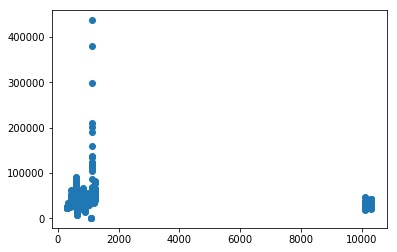

In [51]:
print(daily_sum.columns.values)
plt.scatter(daily_sum['data_date'] - 20170000, daily_sum['sales_uv'])


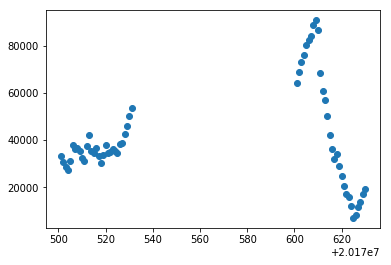

In [50]:
first2mons_daily_sum = daily_sum[(20170500 < daily_sum['data_date']) & (daily_sum['data_date'] < 20170700)]
plt.scatter(first2mons_daily_sum['data_date'], first2mons_daily_sum['sales_uv'])

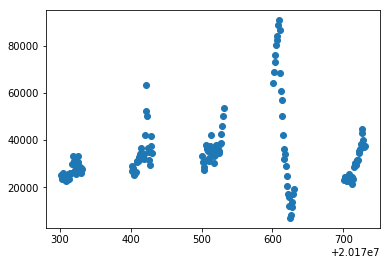

In [52]:
first2mons_daily_sum = daily_sum[(20170300 < daily_sum['data_date']) & (daily_sum['data_date'] < 20170800)]
plt.scatter(first2mons_daily_sum['data_date'], first2mons_daily_sum['sales_uv'])

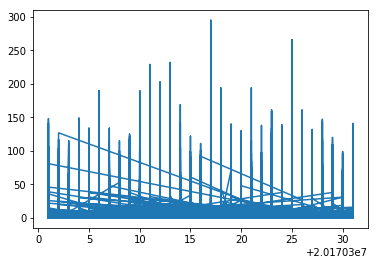

In [26]:
first2months = goodsdaily[goodsdaily['data_date'] < 20170400]
plt.plot(first2months['data_date'], first2months['sales_uv'])

In [9]:
goods_promote_price.head(5)
goods_promote_price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24016430 entries, 0 to 24016429
Data columns (total 6 columns):
data_date             int64
goods_id              object
shop_price            float64
promote_price         float64
promote_start_time    object
promote_end_time      object
dtypes: float64(2), int64(1), object(3)
memory usage: 1.1+ GB
